In [ ]:
from modified_diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers import AutoencoderKL, StableDiffusionPipeline
import torch
import numpy as np
import os

In [ ]:
#ckpt_path='/home/user/stable-diffusion-webui/models/Stable-diffusion/dreamshaper_331BakedVae.safetensors'
#pipe = StableDiffusionPipeline.from_ckpt(ckpt_path)
#pipe.vae = AutoencoderKL.from_pretrained('lint/anime_vae')

pipe = StableDiffusionPipeline.from_pretrained('lint/simpathizer')


In [ ]:
pipe = StableDiffusionControlNetPipeline(
    **pipe.components,
    #controlnet=ControlNetModel.from_pretrained('../models/controlstyle/checkpoint-44000/'),
    controlnet=ControlNetModel.from_pretrained('lint/simpathizer', subfolder='controlnet'),
)



In [ ]:
pipe.feature_extractor = None
pipe.safety_checker = None
pipe.requires_safety_checker = False
#pipe.enable_xformers_memory_efficient_attention()

for component in pipe.components.values():
    if isinstance(component, torch.nn.Module):
        component.to('cuda', torch.float16)


In [ ]:
prompt = "beautiful woman with blue eyes"

controlnet_prompt = "1girl, blue eyes"


In [ ]:
conditioning_scales = np.linspace(0, 1, 101)

output_dir = '../archive/style_interp'
os.makedirs(output_dir, exist_ok=True)

for cond_scale in conditioning_scales:
    result = pipe(
        prompt=prompt, 
        generator=torch.Generator().manual_seed(2048), 
        controlnet_conditioning_scale=cond_scale,
        controlnet_prompt=controlnet_prompt,
    )

    result.images[0].save(f'{output_dir}/conditioning_scale_{np.around(cond_scale,2)}.png')

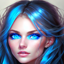

In [20]:
frames[0].resize((64,64))

In [21]:
# make gif

from glob import glob
from PIL import Image

save_dir = '../archive'
resolution = (128, 128)

frames = [Image.open(image).resize(resolution) for image in sorted(glob(f"{output_dir}/*.png"))]

frames[0].save(f"{save_dir}/blue_eyes.gif", format="GIF", append_images=frames+frames[::-1],
               save_all=True, duration=int(1000/30), loop=0)

In [ ]:
# make image grid

from PIL import Image
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

images = []
image_dir = output_dir

for image_path in sorted(Path(image_dir).glob('*.png')):
    images.append(read_image(str(image_path)))

grid = make_grid(images, nrow=11)
grid = grid.permute(1,2,0).numpy()
image_grid = Image.fromarray(grid)
image_grid.save(Path(image_dir).parent/f'{Path(output_dir).name}_grid.png')